### First let's set up the project

We'll be using pandas and numpy for data handling, beautifulsoup for html data extraction, spacy for text cleaning and word embeddings and sklearn for model training and evaluation

In [1]:
# !pip install -r requirements.txt

In [2]:
# !python -m spacy download de_core_news_sm

In [3]:
from warnings import filterwarnings

filterwarnings("ignore")

In [32]:
import os
import re
from pprint import pprint

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

### Next we'll extract texts from provided HTML files 

We'll decompose `style` and `script` tags as they are not our actual textual data and then extract all other texts from files for further processing.

In [5]:
def extract_html_text(filepath: str) -> str:
    """
    Extracts test data from HTML file on provided path.
    """
    # Open the file and load it to BeautifulSoup
    with open(filepath, encoding='ISO-8859-1') as f:
        soup = BeautifulSoup(f.read(), "html")
    
    # Decompose script and style tags
    tags_to_decompose = [
        tag 
        for tag_name in ("style", "script")
        for tag in soup.find_all(tag_name)
    ]
    for tag in tags_to_decompose:
        tag.decompose()
    
    # Return only texts from the file
    return soup.get_text(" ")

# Test the function on a single file
extract_html_text(os.path.join("htmls", "0.html"))

'\n \n \n \n \n \n \n BauchspeicheldrÃ¼se | Klinik fÃ¼r Allgemein-, Viszeral- und Kinderchirurgie GÃ¶ttingen \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Klinik fÃ¼r Allgemein-, Viszeral- und Kinderchirurgie \n zur Hauptnavigation springen \n zum Inhalt wechseln \n \n Aktuelles und Kontakt Kontakt \n \n \n Logo der UniverstÃ¤tsmedizin GÃ¶ttingen \n \n \n \n \n \n \n \n \n \n Navigation Ã¶ffnen oder schliessen \n \n \n \n \n \n \n Hauptnavigation Subnavigation Ã¶ffnen oder schliessen Medizinische Versorgung Poliklinik Sonographie SchilddrÃ¼se SpeiserÃ¶hre und Magen Darm BauchspeicheldrÃ¼se CED Leber und Galle Hernien Koloproktologie Adipositaschirurgie Kinderchirurgie Sarkomchirurgie HIPEC Roboterchirurgie InterdisziplinÃ¤re Zentren Subnavigation Ã¶ffnen oder schliessen Forschung Klinische Studien Tumorepigenetik AG Conradi AG Gaedcke AG Grade AG Krause AG Sperling AG Sprenger AG Wegwitz Promotion Publikationen Subnavigation Ã¶ffnen oder schliessen Lehre Module Blockpraktikum Famulature

Let's define a function that will extract data from all files and return it as a dictionary with document ids as keys and texts as values.

In [6]:
def extract_all_texts(directory) -> dict[int, str]:
    """
    Extracts texts from all HTML files in provided directory
    """
    return {
        int(file.replace(".html", "")): extract_html_text(os.path.join(directory, file))
        for file in os.listdir("htmls")
    }

all_texts = extract_all_texts("htmls")

### Now let's load our training data

We'll load the data to pandas DataFrame to make further processing easier

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df

,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3
...,...,...,...
95,http://www.unicross.uni-freiburg.de/thema/unifm/,140,1
96,http://www.uniklinik-duesseldorf.de/patienten-...,141,1
97,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,144,2
98,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,145,2


Let's remove `url` column as it's not needed and load texts to another column

In [8]:
for df_ in (train_df, test_df):
    del df_['url']
    df_['text'] = df_['doc_id'].apply(lambda x: all_texts[x])
train_df

,doc_id,label,text
0,1,1,\n \n \n \n \n \n \n \n Elbe-Elster Klinikum -...
1,3,3,\n \n \n \n \n \n \n \n Onkologisches Zentrum ...
2,4,1,\n \n \n Zentrum - SozialpÃ¤diatrisches Zentru...
3,5,1,\n \n \n Leistung - Spezielle UnterstÃ¼tzung b...
4,6,3,\n \n \n Zuweiser - Tumorkonferenzen - Tumorko...
...,...,...,...
95,140,1,\n \n \n \n \n \n \n \n \n \n \n \n uniFM | un...
96,141,1,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
97,144,2,\n \n \n \n \n \n \n \n \n \n \n \n \n FÃ¼r Ã...
98,145,2,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n I...


Let's also check how much data we have for each label

In [9]:
train_df.label.value_counts()

2    59
1    32
3     9
Name: label, dtype: int64

As we can see there's a huge imbalance in our data distribution. We'll try to tackle this issue with a couple of approaches:
- oversamling of the least populated group
- grouping labels 2 and 3 together to perform binary classification

But first let's clean our data.

### Now we'll be cleaning and tokenizing our data

For that purpose we'll use spacy and it's pre-trained German language model. We'll be using the smallest one available, larger ones could provide better performence, however they're quite big and slow.

In [10]:
nlp = spacy.load("de_core_news_sm")

Let's define our tokenizing and cleaning functions

In [11]:
def preprocessor(text: str) -> str:
    """
    Removes punctuation from text using regular expressions
    """
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[\W]+', '', text.lower())
    text = re.sub('^\d+$', '', text)
    
    return text


def tokenize(sent: spacy.tokens.Span) -> list[str]:
    """
    Extracts a list of word lemmas from spacy's sentence object.
    Stopwords are filtered out as well as tokens representing only
    whitespace or punctuation.
    """
    lemmas = [
        preprocessor(token.lemma_)
        for token in sent
        if all([
            not token.is_stop,
            token.pos_ not in {"SPACE", "PUNCT"}
        ])
    ]
    return [lem for lem in lemmas if lem]


def tokenize_all(text: str) -> list[list[str]]:
    """
    Parses text to a list of lists. 
    Each list inside the main list represents a sentence in text.
    All tokens in the sentence are cleaned, lemmatized and filtered.
    """
    global nlp
    
    doc = nlp(text)
    
    return [
        tok
        for sent in doc.sents
        for tok in tokenize(sent)
    ]

And now apply them to our texts

In [12]:
for df_ in (train_df, test_df):
    df_['tokens'] = df_['text'].apply(tokenize_all)
    df_['clean_text'] = df_['tokens'].apply(lambda toks: " ".join(toks))
    
train_df

,doc_id,label,text,tokens,clean_text
0,1,1,\n \n \n \n \n \n \n \n Elbe-Elster Klinikum -...,"[elbeelster, klinikum, chirurgie, finsterwalde...",elbeelster klinikum chirurgie finsterwalde suc...
1,3,3,\n \n \n \n \n \n \n \n Onkologisches Zentrum ...,"[onkologisches, zentrum, klinikum, bayreuth, a...",onkologisches zentrum klinikum bayreuth aktuel...
2,4,1,\n \n \n Zentrum - SozialpÃ¤diatrisches Zentru...,"[zentrum, sozialpãdiatrisches, zentrum, stãdti...",zentrum sozialpãdiatrisches zentrum stãdtische...
3,5,1,\n \n \n Leistung - Spezielle UnterstÃ¼tzung b...,"[leistung, speziell, unterstã¼tzung, anmeldung...",leistung speziell unterstã¼tzung anmeldung geb...
4,6,3,\n \n \n Zuweiser - Tumorkonferenzen - Tumorko...,"[zuweiser, tumorkonferenzen, tumorkonferenz, g...",zuweiser tumorkonferenzen tumorkonferenz gastr...
...,...,...,...,...,...
95,140,1,\n \n \n \n \n \n \n \n \n \n \n \n uniFM | un...,"[unifm, unicross, news, and, magazin, theme, h...",unifm unicross news and magazin theme home kon...
96,141,1,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,"[interdisziplinãre, neurovaskulãre, konferenz,...",interdisziplinãre neurovaskulãre konferenz ǀ u...
97,144,2,\n \n \n \n \n \n \n \n \n \n \n \n \n FÃ¼r Ã...,"[fã¼r, ãrzte, vivantes, javascript, scheinen, ...",fã¼r ãrzte vivantes javascript scheinen browse...
98,145,2,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n I...,"[innere, medizin, â, hãmatologie, onkologie, p...",innere medizin â hãmatologie onkologie palliat...


Now we'll oversample our data so that there are 20 samples for label 3

In [13]:
class_3_oversample = train_df[train_df.label == 3].sample(20, replace=True, random_state=0)
os_train_df = pd.concat([train_df[train_df.label != 3], class_3_oversample])
os_train_df.label.value_counts()

2    59
1    32
3    20
Name: label, dtype: int64

### Text vectors

Now we'll transform text data into vectors. First we'll try to use spacy's pre-defined word embeddings from the language model we're using.

In [14]:
os_train_df['spacy_vectors'] = os_train_df['clean_text'].apply(lambda txt: nlp(txt).vector)
os_train_df['spacy_vectors'][0].shape

(96,)

### Model training

This is time to finally try out our data on an actual model. We'll start with a simple LogisticRegression. But first we'll define model evaluating functions.

In [15]:
def eval_model(
    clf: BaseEstimator, 
    x_test: np.ndarray, 
    y_test: np.ndarray
) -> None:
    """
    Calculates and displays evaluation metrics 
    for passed classifier and data
    """
    y_pred = clf.predict(x_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    plot_confusion_matrix(clf, x_test, y_test)
    plt.show()
    
    print(f'Accuracy {acc}\n')
    print(report)
    
    
def fit_and_eval(
    clf: BaseEstimator, 
    X_trn: np.ndarray, 
    x_test: np.ndarray, 
    Y_trn: np.ndarray, 
    y_test: np.ndarray
) -> BaseEstimator:
    """
    Trains and evaluates passed classifier
    with passed data
    """
    clf.fit(X_trn, Y_trn)
    
    eval_model(clf, x_test, y_test)
    
    return clf

Now split the data for training and evalutation.

In [16]:
x, y = np.stack(os_train_df.spacy_vectors), os_train_df.label.to_numpy()
X_train, x_val, Y_train, y_val = train_test_split(x, y, train_size=0.9, shuffle=True, random_state=1, stratify=y)

And train the model.

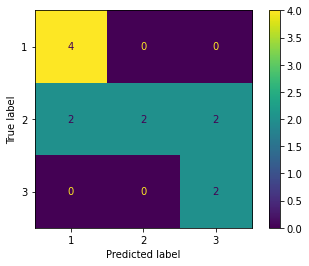

Accuracy 0.6666666666666666

              precision    recall  f1-score   support

           1       0.67      1.00      0.80         4
           2       1.00      0.33      0.50         6
           3       0.50      1.00      0.67         2

    accuracy                           0.67        12
   macro avg       0.72      0.78      0.66        12
weighted avg       0.81      0.67      0.63        12



In [17]:
lgr = fit_and_eval(
    LogisticRegression(n_jobs=10, C=1, class_weight="balanced"),
    X_train, x_val, Y_train, y_val
)

Results aren't outstanding.

Now we'll try to use word vectors retrieved by using TF-IDF and compare the results. We'll pass provided tumorboard keywords as vectorizer's vocabulary.

In [18]:
kw2tt = pd.read_csv("keyword2tumor_type.csv")

In [19]:
tfidf_vec = TfidfVectorizer(vocabulary=kw2tt.keyword)
vectors = tfidf_vec.fit([*train_df.clean_text, *test_df.clean_text])

os_train_df['tfidf_vectors'] = tfidf_vec.transform(os_train_df.clean_text).todense().tolist()
os_train_df

,doc_id,label,text,tokens,clean_text,spacy_vectors,tfidf_vectors
0,1,1,\n \n \n \n \n \n \n \n Elbe-Elster Klinikum -...,"[elbeelster, klinikum, chirurgie, finsterwalde...",elbeelster klinikum chirurgie finsterwalde suc...,"[-0.53063667, 0.2895801, 0.9528262, 0.1834897,...","[0.0, 0.23551310942693068, 0.0, 0.0, 0.0, 0.0,..."
2,4,1,\n \n \n Zentrum - SozialpÃ¤diatrisches Zentru...,"[zentrum, sozialpãdiatrisches, zentrum, stãdti...",zentrum sozialpãdiatrisches zentrum stãdtische...,"[-0.5575327, -0.081390426, 0.57074475, 0.19425...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5,1,\n \n \n Leistung - Spezielle UnterstÃ¼tzung b...,"[leistung, speziell, unterstã¼tzung, anmeldung...",leistung speziell unterstã¼tzung anmeldung geb...,"[-0.6617667, -0.1581502, 0.7799465, 0.25224572...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,8,1,\n \n \n \n Krebszentrum Reutlingen: Impressum...,"[krebszentrum, reutlingen, impressum, kreiskli...",krebszentrum reutlingen impressum kreisklinike...,"[-0.08251338, -0.26053467, 0.7124723, 0.159013...","[0.0, 0.27401512797076716, 0.0, 0.0, 0.0, 0.0,..."
6,9,1,\n \n \n \n Ãsthetische Brustchirurgie - kreb...,"[ãsthetische, brustchirurgie, krebszentrumkrei...",ãsthetische brustchirurgie krebszentrumkreiskl...,"[-0.056941252, -0.20380035, 0.7193041, 0.21975...","[0.0, 0.7448209232909639, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
65,100,3,\n \n \n \n \n \n Ãrztliche Weiterbildung \n ...,"[ãrztliche, weiterbildung, impressum, datensch...",ãrztliche weiterbildung impressum datenschutz ...,"[-0.66163003, 0.22765392, 1.1872609, 0.0680871...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.584..."
65,100,3,\n \n \n \n \n \n Ãrztliche Weiterbildung \n ...,"[ãrztliche, weiterbildung, impressum, datensch...",ãrztliche weiterbildung impressum datenschutz ...,"[-0.66163003, 0.22765392, 1.1872609, 0.0680871...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.584..."
67,102,3,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,"[tumorkonferenz, x, unternehmen, karriere, kon...",tumorkonferenz x unternehmen karriere kontakt ...,"[-0.7174796, 0.226036, 0.87725824, 0.2759676, ...","[0.0, 0.5500855093740707, 0.0, 0.0, 0.0, 0.0, ..."
4,6,3,\n \n \n Zuweiser - Tumorkonferenzen - Tumorko...,"[zuweiser, tumorkonferenzen, tumorkonferenz, g...",zuweiser tumorkonferenzen tumorkonferenz gastr...,"[-0.8314079, -0.01758165, 0.74393255, 0.143312...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.141..."


Vectorizing with TF-IDF is much faster than computing average text vectors with spacy. Let's check how it works out.

In [20]:
x, y = np.stack(os_train_df.tfidf_vectors), os_train_df.label.to_numpy()
X_train, x_val, Y_train, y_val = train_test_split(x, y, train_size=0.9, shuffle=True, random_state=1, stratify=y)

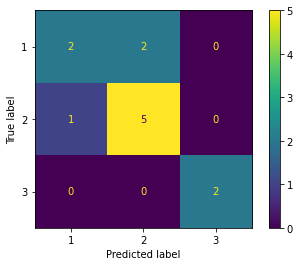

Accuracy 0.75

              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.71      0.83      0.77         6
           3       1.00      1.00      1.00         2

    accuracy                           0.75        12
   macro avg       0.79      0.78      0.78        12
weighted avg       0.75      0.75      0.74        12



In [21]:
lgr = fit_and_eval(
    LogisticRegression(n_jobs=10, C=1, class_weight="balanced"),
    X_train, x_val, Y_train, y_val
)

TF-IDF vectors gave us better results than spacy's word embeddings. Because of this and their faster generation time we'll stick to them.

Maybe using larger language model could improve word embeddings performance, however due to reasons I mentioned before we won't be using them.

In [22]:
del os_train_df['spacy_vectors']

Let's try out some other models for this task.

First - support vector machine model.

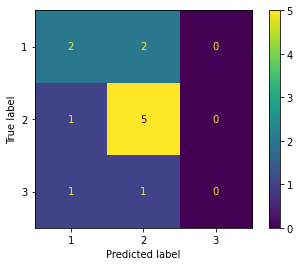

Accuracy 0.5833333333333334

              precision    recall  f1-score   support

           1       0.50      0.50      0.50         4
           2       0.62      0.83      0.71         6
           3       0.00      0.00      0.00         2

    accuracy                           0.58        12
   macro avg       0.38      0.44      0.40        12
weighted avg       0.48      0.58      0.52        12



In [31]:
svc = fit_and_eval(
    LinearSVC(penalty='l2', loss='hinge', dual=True, random_state=0, max_iter=100),
    X_train, x_val, Y_train, y_val
)

As we can see the results are worse than with LogisticRegression.

Now let's try out a Linear Support Vector Machine with l1 regularization.

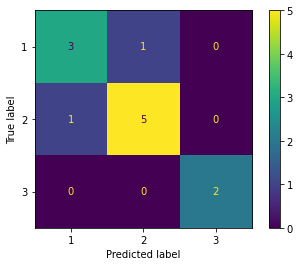

Accuracy 0.8333333333333334

              precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         2

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.86        12
weighted avg       0.83      0.83      0.83        12



In [24]:
sgd = fit_and_eval(
    SGDClassifier(penalty='l1', loss='hinge', alpha=1e-3, random_state=0, max_iter=100),
    X_train, x_val, Y_train, y_val
)

This model gave us the best performance from all the ones tried.

### Binary approach

Another approach we can try is to convert labels to binary. As labels 2 and 3 mean similar things but with different level of certainity we can try to group them together. With this approach however we'd need a way to differentiate between those two classes afterwards. We could use prediction probability for this task.

In [25]:
Y_train_bin = np.array([2 if l == 3 else l for l in Y_train])
y_val_bin = np.array([2 if l == 3 else l for l in y_val])

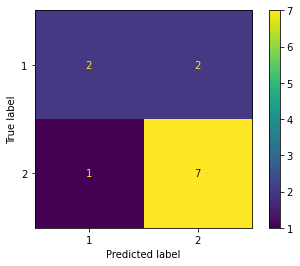

Accuracy 0.75

              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.78      0.88      0.82         8

    accuracy                           0.75        12
   macro avg       0.72      0.69      0.70        12
weighted avg       0.74      0.75      0.74        12



In [26]:
sgd_bin = fit_and_eval(
    SGDClassifier(penalty='l1', loss='hinge', alpha=1e-3, random_state=0, max_iter=100),
    X_train, x_val, Y_train_bin, y_val_bin
)

As we can see results for binary classification in this case turn out to be worse than for multiclassification so we'll abandon this path.

### Final algorithm

We'll train the model again with the same configuration, but on all training data this time

In [27]:
x, y = np.stack(os_train_df.tfidf_vectors), os_train_df.label.to_numpy()
clf = SGDClassifier(penalty='l1', loss='hinge', alpha=1e-3, random_state=0, max_iter=100)
clf.fit(x, y)

SGDClassifier(alpha=0.001, max_iter=100, penalty='l1', random_state=0)

Now we'll transform test data texts to vectors with the previously trained TF-IDF vectorizer and predict classes

In [28]:
test_df['vectors'] = tfidf_vec.transform(test_df['clean_text']).todense().tolist()
test_df['prediction'] = clf.predict(np.stack(test_df['vectors']))
    
test_df.prediction.value_counts()

2    38
1     8
3     2
Name: prediction, dtype: int64

Finally let's save our results to file.

In [29]:
result_df = test_df[['doc_id', 'prediction']]
result_df.to_csv("submission.csv")

### Extra mile

In [97]:
from collections import Counter, defaultdict

In [98]:
kw2tt.tumor_type.unique()

array(['Brust', 'Darm', 'Endokrine malignome',
       'Gallenblasen/gallengangkrebs', 'Gynäkologie', 'Harnblase', 'Haut',
       'Hoden, penis', 'Hämatooncology', 'Kopf-hals', 'Leber', 'Lunge',
       'Lymphom', 'Magen', 'Mamma carcinoma', 'Neuroonkologie', 'Niere',
       'Pankreas', 'Prostata', 'Rare cancer', 'Sarkome', 'Speiseröhre',
       'Urologische', 'Adenoid', 'Adrenal', 'Bauchspeicheldrüsenkrebs',
       'Interdisziplinär', 'Knochentumoren', 'Mikroskopieren',
       'Molekular', 'Oral', 'Prätherapeutische', 'Pädiatrische',
       'Schwerpunkt', 'Stammzelltransplantation', 'Surgical'],
      dtype=object)

In [99]:
test_df.columns = [
    "label" if col == "prediction" else col
    for col in test_df.columns
]

full_df = pd.concat([
    train_df[['doc_id', 'label', 'clean_text']],
    test_df[['doc_id', 'label', 'clean_text']]
])
tb_df = full_df[full_df['label'].apply(lambda l: l in {2, 3})]
tb_df

,doc_id,label,clean_text
1,3,3,onkologisches zentrum klinikum bayreuth aktuel...
4,6,3,zuweiser tumorkonferenzen tumorkonferenz gastr...
10,13,2,krebszentrum reutlingen zentrale einrichtung k...
11,14,2,leistungsspektrum sankt marienhospital buer gm...
12,17,2,minimalinvasive chirurgie sankt marienhospital...
...,...,...,...
42,127,2,vendor neutral archiving solutions vna siemens...
43,134,2,zweitmeinung â einschãtzung sinnvoll universit...
45,142,2,tumorboard lungenkrebszentrums mãglicherweise ...
46,143,2,oberarzt m w d hnoklinik a a notfall rettungsl...


In [100]:
tfidf_feature_names = tfidf_vec.get_feature_names()
kw2tt_dict = dict(zip(kw2tt.keyword, kw2tt.tumor_type))

In [101]:
def sort_coo(coo_matrix):
    """
    
    """
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_tb_type(feature_names, sorted_items):
    """
    
    """
    global kw2tt_dict
    
    tt_scores = defaultdict(list)
    for idx, score in sorted_items:
        kw = feature_names[idx]
        tumor_type = kw2tt_dict[kw]
        
        tt_scores[tumor_type].append(score)
    
    if not tt_scores:
        return None
    
    tt_mean_scores = {
        tt: np.mean(scores)
        for tt, scores in tt_scores.items()
    }
    
    tumor_type, _ = max(
        tt_mean_scores.items(), 
        key=lambda x: x[1]
    )
    
    return tumor_type

def get_tumor_type(text):
    """
    
    """
    global tfidf_vec
    global tfidf_feature_names
    
    vec = tfidf_vec.transform([text])
    
    sorted_items = sort_coo(vec.tocoo())
    
    tumor_type = extract_tb_type(
        tfidf_feature_names, sorted_items
    )
    
    return tumor_type

In [105]:
tb_df['tumor_type'] = tb_df['clean_text'].apply(get_tumor_type)
tb_df.tumor_type.value_counts()

Darm                            22
Schwerpunkt                     19
Brust                           11
Lunge                            9
Magen                            7
Interdisziplinär                 6
Leber                            5
Haut                             5
Urologische                      4
Endokrine malignome              3
Mamma carcinoma                  3
Surgical                         3
Pädiatrische                     2
Sarkome                          2
Hämatooncology                   2
Knochentumoren                   1
Neuroonkologie                   1
Gallenblasen/gallengangkrebs     1
Name: tumor_type, dtype: int64

In [106]:
weekdays = {'sonntag', 'montag', 'dienstag', 'mittwoch', 'donnerstag', 'freitag', 'samstag'}

def detect_weekday(text):
    global weekdays
    
    tokens = text.split()
    found_weekdays = set(tokens).intersection(weekdays)
    word_counts = Counter(tokens)
    
    weekday_counts = defaultdict(int)
    for wd in found_weekdays:
        weekday_counts[wd] += word_counts[wd]
    
    if not weekday_counts:
        return None
    
    most_freq_wd, _ = max(weekday_counts.items(), key=lambda x: x[1])
    
    return most_freq_wd

In [107]:
tb_df['weekday'] = tb_df['clean_text'].apply(detect_weekday)
tb_df

,doc_id,label,clean_text,tumor_type,weekday
1,3,3,onkologisches zentrum klinikum bayreuth aktuel...,Brust,donnerstag
4,6,3,zuweiser tumorkonferenzen tumorkonferenz gastr...,Magen,dienstag
10,13,2,krebszentrum reutlingen zentrale einrichtung k...,Interdisziplinär,None
11,14,2,leistungsspektrum sankt marienhospital buer gm...,Schwerpunkt,None
12,17,2,minimalinvasive chirurgie sankt marienhospital...,Schwerpunkt,None
...,...,...,...,...,...
42,127,2,vendor neutral archiving solutions vna siemens...,Hämatooncology,None
43,134,2,zweitmeinung â einschãtzung sinnvoll universit...,Urologische,None
45,142,2,tumorboard lungenkrebszentrums mãglicherweise ...,Lunge,mittwoch
46,143,2,oberarzt m w d hnoklinik a a notfall rettungsl...,Schwerpunkt,None


In [112]:
tb_df[~tb_df.weekday.isna()].shape

(28, 5)